In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

# sets the default float-type
tf.keras.backend.set_floatx('float32')

class AxialBar1D:

  def __init__(self, xmin, xmax, q, N=1000, num_hidden_layers=1, num_neurons_per_layer=20, activation='tanh', actual_solution=None, epochs=5000):

    self.N = N
    self.epochs = epochs
    self.xmin = xmin
    self.xmax = xmax
    self.model = self.initialize_NN(num_hidden_layers, num_neurons_per_layer, activation)
    self.X = self.get_data()
    self.q = q
    self.learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,10000],[1e-2,1e-4,5e-5])
    """It helps to get a different learning rate ate different intervals steps
    like for 0-3000, LR will be 1e-2
    for 3000-10000, LR will be 1e-4
    and beyond that, LR will be 5e-5"""
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    self.actual_solution = actual_solution
  
"Fetching data from input"
  def get_data(self):

    X = tf.random.uniform((self.N, 1), minval=self.xmin, maxval=self.xmax)
    X = tf.expand_dims(tf.sort(tf.squeeze(X)), axis=-1)
    return X
  
  def initialize_NN(self, num_hidden_layers, num_neurons_per_layer, activation):
    model = tf.keras.Sequential()
    # Add input layer
    model.add(tf.keras.Input(1))
    # Add the hidden layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation, kernel_initializer='glorot_normal'))
        
    # Add output layer
    model.add(tf.keras.layers.Dense(1))
    return model
  
  def psi(self, dudx):
    return (1+dudx)**1.5 - 1.5*dudx - 1
  
    "Trapezoidal Integration function"
  def trapz(self, potential_energy, u):

    h = (self.xmax - self.xmin)/self.N
    integrand = potential_energy - self.q(self.X)*u
    integrand1 = integrand[1:]
    integrand0 = integrand[:-1]
    integral = (h/2)*tf.reduce_sum(integrand1 + integrand0)
    return integral

  def get_loss(self):

    with tf.GradientTape(persistent=True) as tape:
      x = self.X
      x_b1 = tf.ones((1, 1), dtype=tf.float32)*self.xmin
      x_b2 = tf.ones((1,1), dtype=tf.float32)*self.xmax
      tape.watch(x)
      tape.watch(x_b2)
      tape.watch(x_b1)

      # Find u (output of the model)
      u = self.model(x)
      dudx = tape.gradient(u, x)
      tape.watch(dudx)
      psi_of_x = self.psi(dudx)
      psi_grad = tape.gradient(psi_of_x, dudx)
      # Perform trapeoidal integration
      # integrand = psi_of_x - self.q*u
      # potential_energy = (self.xmax-self.xmin)*integrand
      # integral = self.trapz(psi_of_x, u)
      strong_form = tape.gradient(psi_grad, x)
      # Get the boundary loss for the fixed end 
      u_b1 = self.model(x_b1)
      # get the boundary loss for the natural boundary condition
      u_b2 = self.model(x_b2)
      dudx_b2 = tape.gradient(u_b2, x_b2)
    
    loss = tf.reduce_mean(tf.square(strong_form + x)) + tf.square(dudx_b2) + tf.square(u_b1)
    return loss
  
  def get_gradients(self):
    with tf.GradientTape(persistent=True) as tape:
      # This tape is for derivatives with
      # respect to trainable variables
      tape.watch(self.model.trainable_variables)
      loss = self.get_loss()

    g = tape.gradient(loss, self.model.trainable_variables)
    del tape
    return loss, g
  
  @tf.function
  def train_step(self):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = self.get_gradients()
    # Perform gradient descent step
    self.optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
    return loss
  
  def train(self):
    epochs = self.epochs
    hist = []

    # Start timer
    t0 = time()

    for i in range(epochs+1):
        
        loss = self.train_step()
        # Append current loss to hist
        hist.append(loss.numpy())
        # Output current loss after 50 iterates
        if i%50 == 0:
            print(f'It {i}: loss = {loss[0][0].numpy()}')
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

    # Get the mean_absolute error
    predictions = self.predict(self.X)
    if self.actual_solution != None:
      mae = tf.reduce_mean(tf.abs(predictions-self.actual_solution(self.X)))
      mse = tf.reduce_mean(tf.square(predictions-self.actual_solution(self.X)))
      mape = tf.reduce_mean(tf.abs(predictions-self.actual_solution(self.X))/self.actual_solution(self.X))
    else:
      mae = None
      mse = None
      mape = None
    return {'training_history': hist, 'training_time':time()-t0, 'mae': mae, 'mse':mse, 'mape':mape}
  
  def plot_results(self):
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(self.X)
      predicted_solution = self.model(self.X)
      predicted_slope = tape.gradient(predicted_solution, self.X)
      plt.figure(figsize=(10, 10))
      plt.plot(self.X, predicted_solution, label='predicted', color='cyan', linewidth=7 )
      if self.actual_solution != None:
        actual_solution = self.actual_solution(self.X)
        actual_slope = tape.gradient(actual_solution, self.X)
        plt.plot(self.X, actual_solution, label='actual', linestyle='dashed', color='red', linewidth=7)
      plt.xlabel("X")
      plt.ylabel("u(X)")
      plt.title("Axial Loading Prediction")
      plt.legend()
      # Plot the slope
      plt.figure(figsize=(10, 10))
      if self.actual_solution != None:
        plt.plot(self.X, actual_slope, label='actual', color='red', linewidth=7)
      plt.plot(self.X, predicted_slope, linewidth=7, label='predicted', color='lightgreen', linestyle='dashed')
      plt.xlabel("X")
      plt.ylabel("du(X)/dx")
      plt.title("Axial Loading Prediction Slope")
      plt.legend()
      plt.show()
    
  def predict(self, X):
    return self.model.predict(X)


# Experiment 1

N = 1000
epochs = 10000
xmin = -1
xmax = 1
number of hidden layers = 1
number of neurons per layer = 10

It 0: loss = 0.5510430335998535
It 50: loss = 0.08080411702394485
It 100: loss = 0.03666279837489128
It 150: loss = 0.020558146759867668
It 200: loss = 0.014962360262870789
It 250: loss = 0.01083957590162754
It 300: loss = 0.005299075040966272
It 350: loss = 0.0009300924139097333
It 400: loss = 0.0006196014583110809
It 450: loss = 0.0005839610821567476
It 500: loss = 0.000551996286958456
It 550: loss = 0.0005232674302533269
It 600: loss = 0.0004925375687889755
It 650: loss = 0.0004625622241292149
It 700: loss = 0.0004311737429816276
It 750: loss = 0.0003969823301304132
It 800: loss = 0.00035916539491154253
It 850: loss = 0.0003171540447510779
It 900: loss = 0.0002702486817725003
It 950: loss = 0.00022245336731430143
It 1000: loss = 0.00017096189549192786
It 1050: loss = 0.00012587102537509054
It 1100: loss = 0.00011034593626391143
It 1150: loss = 6.398306140908971e-05
It 1200: loss = 4.776638525072485e-05
It 1250: loss = 4.669381814892404e-05
It 1300: loss = 3.425461909500882e-05
It 13

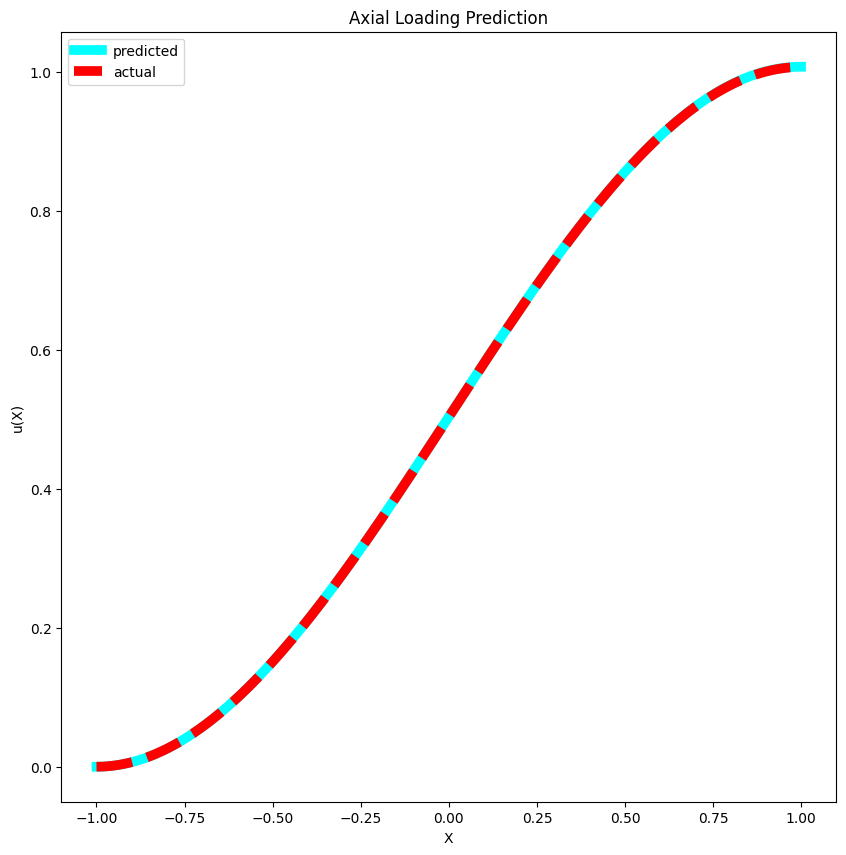

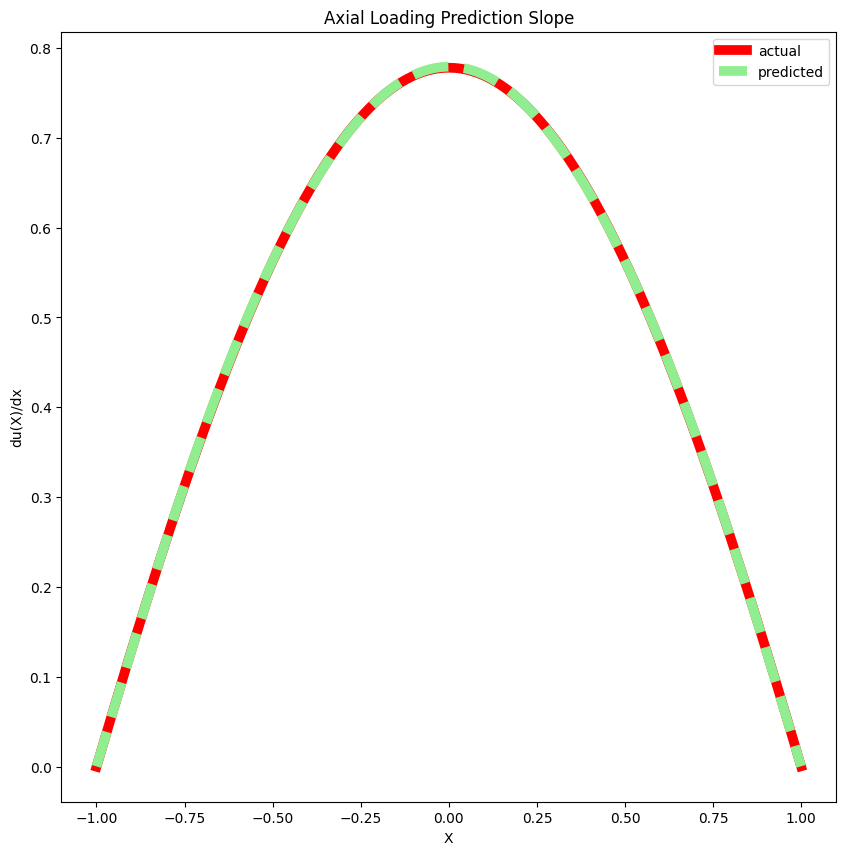

Training time: 6.145782947540283
Mean Absolute Error: 0.00023689570662099868
Mean Squared Error: 7.60854916848075e-08
Mean Absolute Percentage Error: 0.11769583076238632


In [2]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=1,
                   num_neurons_per_layer=10,
                   actual_solution=actual_solution,
                   epochs = 10000)

history = mymodel.train()
mymodel.plot_results()
# Get the training time:
training_time = history['training_time']
mae = history['mae']
mse = history['mse']
mape = history['mape']
print(f'Training time: {training_time}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

# Experiment 2:

N = 1000
epochs = 10000
xmin = -1
xmax = 1
number of hidden layers = 2
number of neurons per layer = 20

It 0: loss = 0.4387466609477997
It 50: loss = 0.018907813355326653
It 100: loss = 0.00906682014465332
It 150: loss = 0.004950000438839197
It 200: loss = 0.002741458360105753
It 250: loss = 0.009936513379216194
It 300: loss = 0.000943455845117569
It 350: loss = 0.00017770494741853327
It 400: loss = 6.543361087096855e-05
It 450: loss = 5.781262370874174e-05
It 500: loss = 0.001904725912027061
It 550: loss = 8.71816446306184e-05
It 600: loss = 6.0765833040932193e-05
It 650: loss = 5.408047582022846e-05
It 700: loss = 4.828390956390649e-05
It 750: loss = 4.508249185164459e-05
It 800: loss = 0.0003818167024292052
It 850: loss = 6.186810787767172e-05
It 900: loss = 5.39312677574344e-05
It 950: loss = 4.767331120092422e-05
It 1000: loss = 4.228902980685234e-05
It 1050: loss = 3.760302206501365e-05
It 1100: loss = 0.0038004375528544188
It 1150: loss = 9.306734136771411e-05
It 1200: loss = 5.4216412536334246e-05
It 1250: loss = 4.689428533311002e-05
It 1300: loss = 4.090018410352059e-05
It 1350

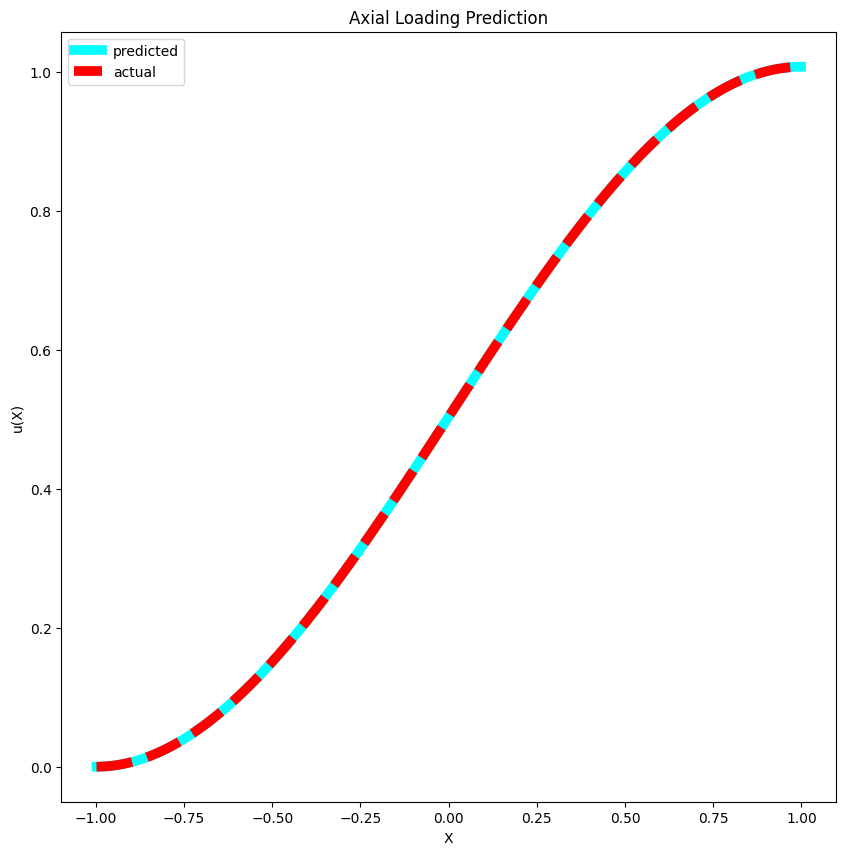

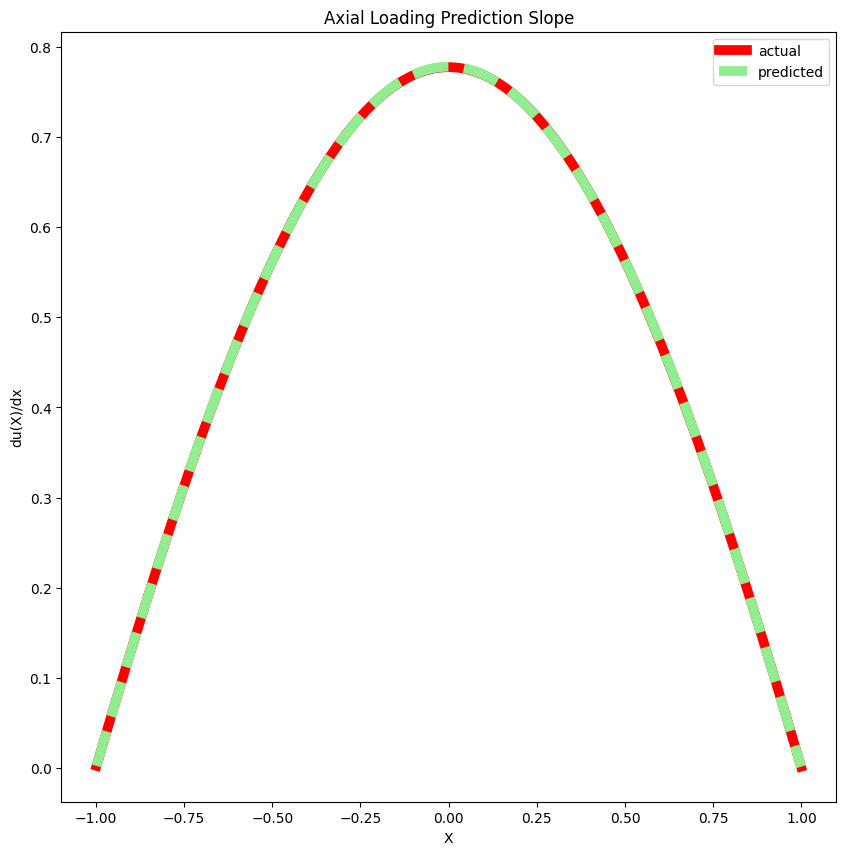

Training time: 10.849639415740967
Mean Absolute Error: 5.4670366807840765e-05
Mean Squared Error: 5.364038102584345e-09
Mean Absolute Percentage Error: 0.002504184143617749


In [3]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel2 = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=2,
                   num_neurons_per_layer=20,
                   actual_solution=actual_solution,
                   epochs = 10000)

history2 = mymodel2.train()
mymodel2.plot_results()
# Get the training time:
training_time2 = history2['training_time']
mae2 = history2['mae']
mse2 = history2['mse']
mape2 = history2['mape']
print(f'Training time: {training_time2}')
print(f'Mean Absolute Error: {mae2}')
print(f'Mean Squared Error: {mse2}')
print(f'Mean Absolute Percentage Error: {mape2}')

# Experiment 3:

N = 1000
epochs = 10000
xmin = -1
xmax = 1
number of hidden layers = 3
number of neurons per layer = 20

It 0: loss = 0.3791523873806
It 50: loss = 0.009550072252750397
It 100: loss = 0.004345053806900978
It 150: loss = 0.0018055561231449246
It 200: loss = 0.0014846979174762964
It 250: loss = 0.00045081437565386295
It 300: loss = 0.0003211901930626482
It 350: loss = 0.0002771577856037766
It 400: loss = 0.00023999111726880074
It 450: loss = 0.00020809278066735715
It 500: loss = 0.002657418604940176
It 550: loss = 0.0002531297504901886
It 600: loss = 0.00021060556173324585
It 650: loss = 0.00018310769519302994
It 700: loss = 0.00015947080100886524
It 750: loss = 0.00013902747014071792
It 800: loss = 0.00012269221770111471
It 850: loss = 0.00050658656982705
It 900: loss = 0.0001544161350466311
It 950: loss = 0.00013155184569768608
It 1000: loss = 0.00011411310697440058
It 1050: loss = 9.969468374038115e-05
It 1100: loss = 8.7734755652491e-05
It 1150: loss = 0.02121182717382908
It 1200: loss = 0.00012943959154654294
It 1250: loss = 0.00010751283844001591
It 1300: loss = 9.357075032312423e-05


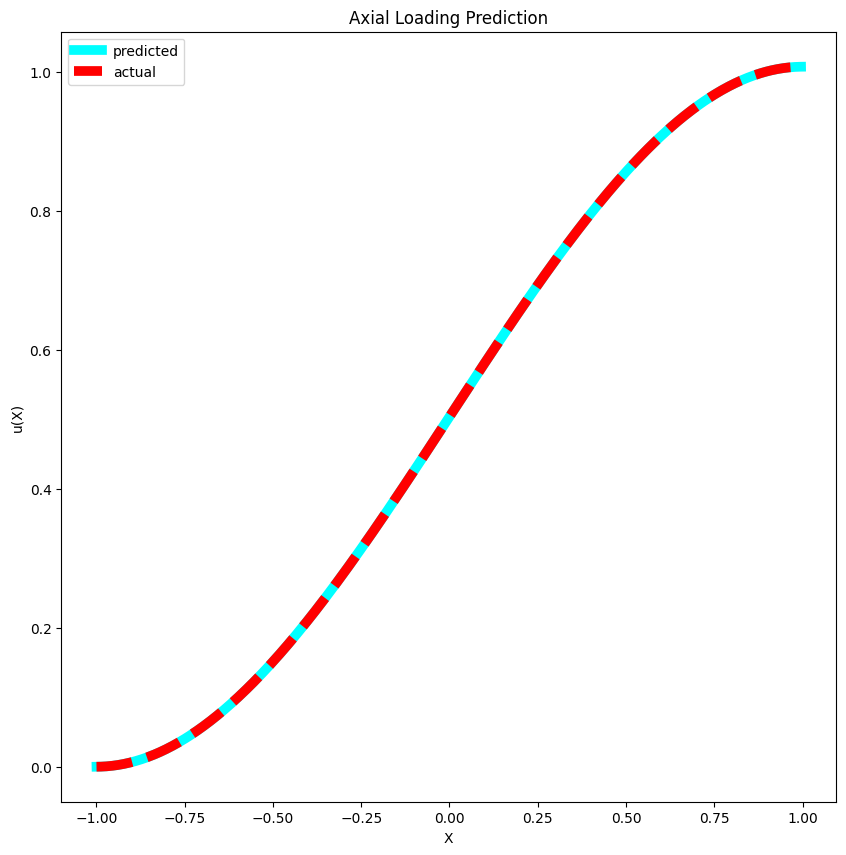

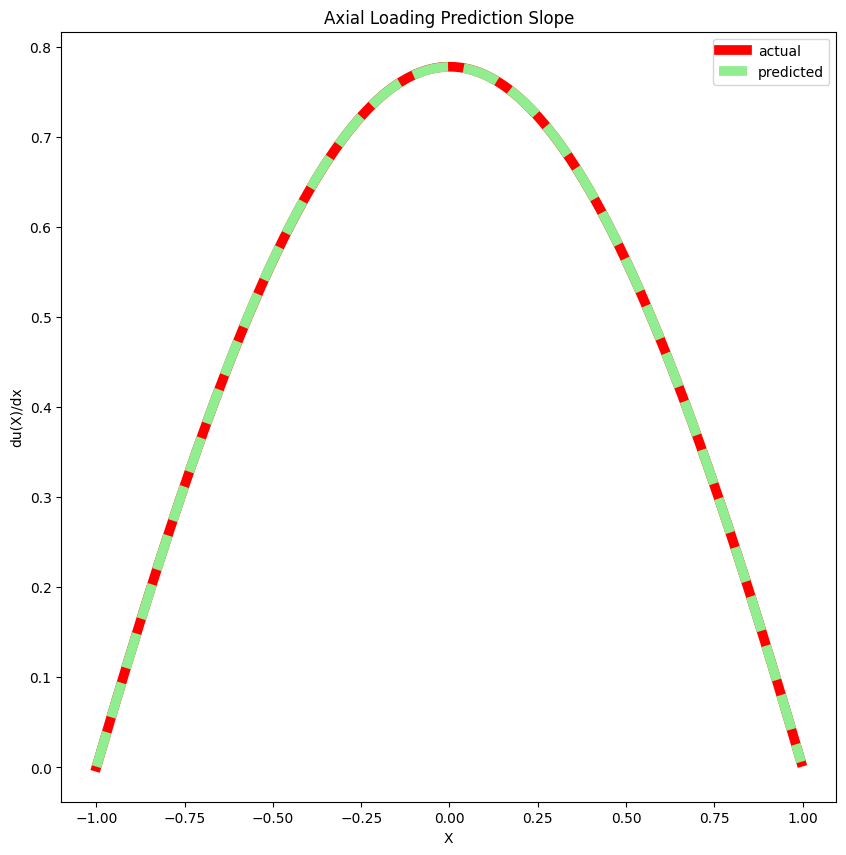

Training time: 14.480062246322632
Mean Absolute Error: 2.3592116122017615e-05
Mean Squared Error: 7.86952003561936e-10
Mean Absolute Percentage Error: 0.008519310504198074


In [4]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel3 = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=3,
                   num_neurons_per_layer=20,
                   actual_solution=actual_solution,
                   epochs = 10000)

history3 = mymodel3.train()
mymodel3.plot_results()
# Get the training time:
training_time3 = history3['training_time']
mae3 = history3['mae']
mse3 = history3['mse']
mape3 = history3['mape']
print(f'Training time: {training_time3}')
print(f'Mean Absolute Error: {mae3}')
print(f'Mean Squared Error: {mse3}')
print(f'Mean Absolute Percentage Error: {mape3}')

# Experiment 4:

N = 10000
epochs = 10000
xmin = -1
xmax = 1
number of hidden layers = 3
number of neurons per layer = 20

It 0: loss = 1.205662727355957
It 50: loss = 0.01969691924750805
It 100: loss = 0.005331125576049089
It 150: loss = 0.0015571501571685076
It 200: loss = 0.0005690865218639374
It 250: loss = 0.00043707454460673034
It 300: loss = 0.0003468467912171036
It 350: loss = 0.00047609704779461026
It 400: loss = 0.00028653338085860014
It 450: loss = 0.00024149887030944228
It 500: loss = 0.00020509246678557247
It 550: loss = 0.01758425496518612
It 600: loss = 0.0003063461044803262
It 650: loss = 0.00018730027659330517
It 700: loss = 0.00016300637798849493
It 750: loss = 0.00014307753008324653
It 800: loss = 0.00012636939936783165
It 850: loss = 0.00011225567868677899
It 900: loss = 0.0024989035446196795
It 950: loss = 0.0001524675462860614
It 1000: loss = 0.00012612981663551182
It 1050: loss = 0.00011303839710308239
It 1100: loss = 0.0001018465482047759
It 1150: loss = 9.211711585521698e-05
It 1200: loss = 8.357532351510599e-05
It 1250: loss = 0.005250695627182722
It 1300: loss = 0.000132320841657

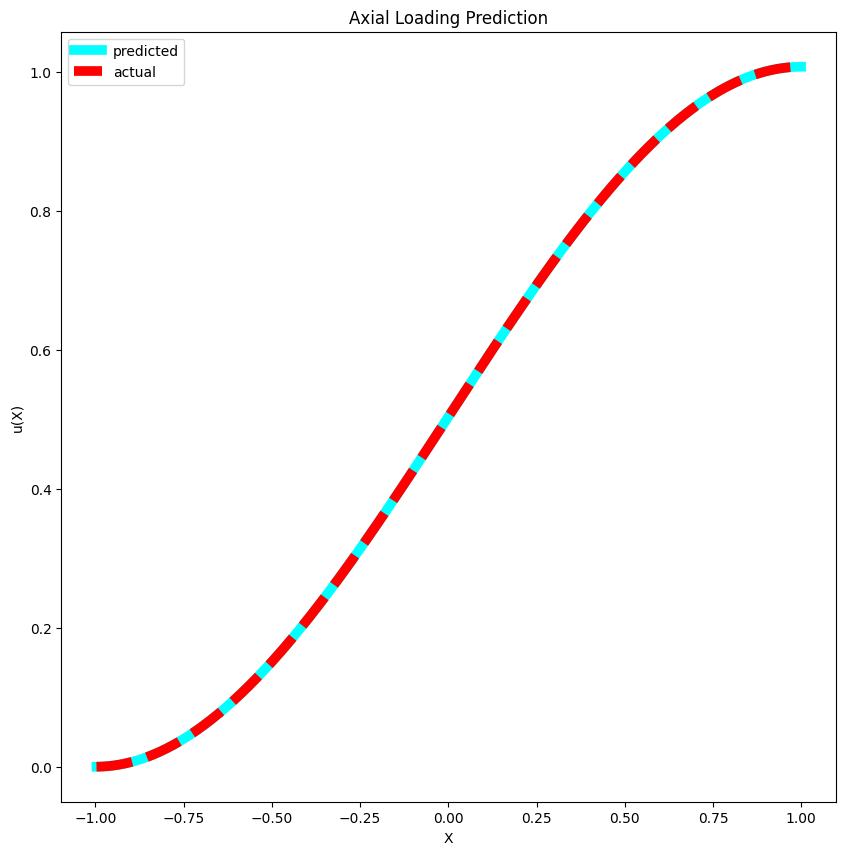

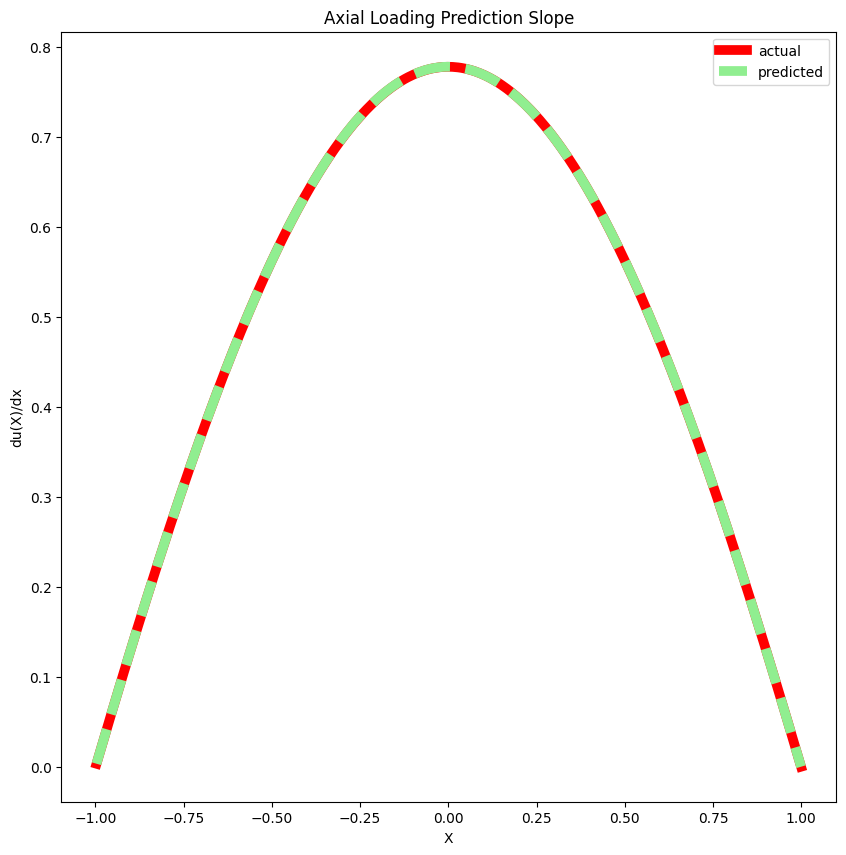

Training time: 14.296941041946411
Mean Absolute Error: 4.8912832426140085e-05
Mean Squared Error: 3.6552625370944725e-09
Mean Absolute Percentage Error: 0.0005797162302769721


In [5]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel4 = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=3,
                   num_neurons_per_layer=20,
                   actual_solution=actual_solution,
                   epochs = 10000)

history4 = mymodel4.train()
mymodel4.plot_results()
# Get the training time:
training_time4 = history4['training_time']
mae4 = history4['mae']
mse4 = history4['mse']
mape4 = history4['mape']
print(f'Training time: {training_time4}')
print(f'Mean Absolute Error: {mae4}')
print(f'Mean Squared Error: {mse4}')
print(f'Mean Absolute Percentage Error: {mape4}')